In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import timm
import torch
from albumentations import (
    Compose,
    Normalize,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    MotionBlur,
    CLAHE,
    HorizontalFlip
)
from copy import deepcopy
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd drive/MyDrive/'BIOMEDIN220-F2022'/

In [4]:
dataset_path = "vinbigdata-chest-xray-resized-png-256x256"
model_path = "vinbigdata-chest-xray-resized-png-256x256/save_models"

csv_path = os.path.join(dataset_path, 'vindrcxr_train.csv')
image_path = os.path.join(dataset_path, 'train') # The path to the folder with converted PNG files
save_path = os.path.join(model_path, '')

print(image_path)

vinbigdata-chest-xray-resized-png-256x256/train


In [5]:
!ls vinbigdata-chest-xray-resized-png-256x256

save_models  train	     vinbigdata-chest-xray-resized-png-256x256.zip
test	     train.csv	     vindrcxr_test.csv
test.csv     train_meta.csv  vindrcxr_train.csv


In [6]:
### Code from https://github.com/Scu-sen/VinBigData-Chest-X-ray-Abnormalities-Detection

class TrainDataset(Dataset):
    
    def __init__(self, df, image_path, transform=None):
        self.df = df
        self.image_path = image_path
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        labels = torch.from_numpy(
            self.df.loc[idx,np.arange(0,15).astype(str).tolist()].values.astype(float)
        ).float()

        img = cv2.imread(
            self.image_path + '/' + str(self.df.image_id[idx]) + '.png'
        )
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
            
        return img, labels

In [7]:
bs = 2
lr = 1e-3
N_EPOCHS = 10

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [9]:
def train_model(model, train_loader, optimizer, criterion): # train 1 epoch
    """
    Trains the model for 1 epoch
    
    Parameters:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): Dataloader object for training.
        optimizer (A torch.optim class): The optimizer.
        criterion (A function in torch.nn.modules.loss): The loss function. 
        
    Return: 
        avg_loss (float): The average loss.
    """
    
    model.train() 
    
    running_loss = 0.0
    running_n = 0
    avg_loss = 0.0
    train_preds, train_targets = [], []

    optimizer.zero_grad()
    
    tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
    for idx, (imgs, labels) in enumerate(tk):
        imgs_train, labels_train = imgs.cuda(), labels.cuda()
        output_train = model(imgs_train)
        
        loss = criterion(output_train, labels_train) 
        loss.backward()

        optimizer.step() 
        optimizer.zero_grad() 
        
        running_loss += loss.item() * imgs_train.size(0)
        running_n += imgs_train.size(0)
        tk.set_postfix(loss=running_loss / running_n)

        train_pred = torch.sigmoid(output_train).detach().cpu().numpy()
        label_train = labels_train.detach().cpu().numpy()
      
        train_preds.append(train_pred)
        train_targets.append(label_train.round().astype(int))
    print(running_n, len(train_loader))
    avg_loss = running_loss / running_n

    train_preds = np.concatenate(train_preds,axis=0).T
    train_targets = np.concatenate(train_targets,axis=0).T
    
    aucs = np.array(
        [roc_auc_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(train_targets, train_preds)]
    )
    overall_auc = np.nanmean(aucs)

    thresholded_train_preds = np.round(train_preds)
    accs = np.array(
        [accuracy_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(train_targets, thresholded_train_preds)]
    )
    overall_acc = np.nanmean(accs)

    return avg_loss, aucs, overall_auc, accs, overall_acc

In [10]:
def val_model(model, val_loader, criterion):
    """
    Test the model on the validation set
    
    Parameters:
        model (torch.nn.Module): The model to be trained.
        val_loader (torch.utils.data.DataLoader): Dataloader object for validation.
        optimizer (A torch.optim class): The optimizer.
        criterion (A torch.nn.modules.loss class): The loss function. 
        
    Return: 
        avg_val_loss (float): The average loss.
        aucs (np.array): The validation AUC of each class.
    """
    model.eval()
    
    running_loss = 0.0
    running_n = 0
    avg_loss = 0.0
    valid_preds, valid_targets = [], []
    
    with torch.no_grad():
        tk = tqdm(val_loader, total=len(val_loader), position=0, leave=True)
        
        for idx, (imgs, labels) in enumerate(tk):  
            imgs_valid, labels_valid = imgs.cuda(), labels.cuda()
            output_valid = model(imgs_valid)
            
            loss = criterion(output_valid, labels_valid)
            running_loss += loss.item() * imgs_valid.size(0)
            running_n += imgs_valid.size(0)
            tk.set_postfix(loss=running_loss / running_n)
            
            valid_pred = torch.sigmoid(output_valid).detach().cpu().numpy()
            label_valid = labels_valid.detach().cpu().numpy()
         
            valid_preds.append(valid_pred)
            valid_targets.append(label_valid.round().astype(int))
        print(running_n, len(val_loader))
        avg_loss = running_loss / running_n

        valid_preds = np.concatenate(valid_preds,axis=0).T
        valid_targets = np.concatenate(valid_targets,axis=0).T
        
        aucs = np.array(
            [roc_auc_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(valid_targets, valid_preds)]
        )
        overall_auc = np.nanmean(aucs)

        thresholded_valid_preds = np.round(valid_preds)
        accs = np.array(
            [accuracy_score(i,j) if len(set(i))>1 else np.nan for i,j in zip(valid_targets, thresholded_valid_preds)]
        )
        overall_acc = np.nanmean(accs)
        
    return avg_loss, aucs, overall_auc, accs, overall_acc

In [11]:
def main():
    seed_everything(42)

    train = pd.read_csv(csv_path)

    train_transform = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(scale_limit = 0.15, rotate_limit = 10, p = 0.5),
        RandomBrightnessContrast(p=0.5),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
    ])
    test_transform = Compose([
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
    ])

    for fold in range(1): # 5
        trainset = TrainDataset(
            train.loc[train['fold']!=fold].reset_index(),
            image_path = image_path,
            transform=train_transform
        )
        train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=bs, num_workers=1,
            shuffle=True 
        )

        valset = TrainDataset(
            train.loc[train['fold']==fold].reset_index(),
            image_path = image_path,
            transform=test_transform
        )
        val_loader = torch.utils.data.DataLoader(
            valset, batch_size=bs, shuffle=False, num_workers=1
        )

        model = timm.create_model('tf_efficientnet_b4_ns',pretrained=True,num_classes=15).cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = torch.nn.BCEWithLogitsLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.1, mode='max')

        best_weights = deepcopy(model.state_dict())
        previous_lr = lr
        best_auc = 0
        best_aucs = [0]*15
        best_val_loss = 100
        es = 0
        
        train_loss_history, val_loss_history = [], []
        acc_train_history, acc_val_history = [], []
        for epoch in range(N_EPOCHS):
            avg_train_loss, aucs_train, auc_train, accs_train, acc_train = train_model(model, train_loader, optimizer, criterion)
            avg_val_loss, aucs_val, auc_val, accs_val, acc_val = val_model(model, val_loader, criterion)
            
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(avg_val_loss)
            acc_train_history.append(acc_train)
            acc_val_history.append(acc_val)
            
            print('epoch:', epoch)
            print("Training Metrics")
            print('lr:', previous_lr, 'train_loss:', avg_train_loss, 'weighted avg auc:',auc_train, 'weighted avg acc:', acc_train)
            print('aucs:',aucs_train)
            print('accs:', accs_train)
            print("Validation Metrics")
            print('lr:', previous_lr, 'val_loss:',avg_val_loss, 'weighted avg auc:',auc_val, 'weighted avg acc:', acc_val)
            print('aucs:',aucs_val)
            print('accs:', accs_val)

            # Record the best weights if either of AUC or val_loss improved.
            if auc_val > best_auc or avg_val_loss < best_val_loss:
                print('saving best weight...')
                best_weights = deepcopy(model.state_dict())
                for k,v in best_weights.items():
                    best_weights[k] = v.cpu()

            # Save the model weight if the AUC of any class is improved. 
            for i in range(len(best_aucs)):
                if aucs_val[i] > best_aucs[i]:
                    best_aucs[i] = aucs_val[i]
                    d = {'weight':model.state_dict(), 'auc':aucs_val[i], 'epoch':epoch}
                    torch.save(d, save_path + f'multilabel_efnb4_v1_cls{i}_fold{fold}.pth')

            # Update best avg_val_loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss

            # Update best weighted../../results/multilabel_cls/v2/ AUC and implement early stop
            if auc_val > best_auc:
                es = 0
                best_auc = auc_val
            else:
                es += 1
                if es > 10:
                    break

            scheduler.step(auc_val)
        print(train_loss_history)
        print(val_loss_history)
        
        plt.plot(range(N_EPOCHS), train_loss_history, label='Training Loss')
        plt.plot(range(N_EPOCHS), val_loss_history, label='Validation Loss')

        # Add in a title and axes labels
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.savefig(save_path + f'multilabel_efnb4_v1_loss_history_fold{fold}.png')
        plt.show()

In [12]:
!nvidia-smi

Tue Dec  6 06:13:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      0MiB / 15360MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
main()

  0%|          | 0/6002 [00:00<?, ?it/s]

12003 6002


  0%|          | 0/1499 [00:00<?, ?it/s]

2997 1499
epoch: 0
Training Metrics
lr: 0.001 train_loss: 0.18711884918504038 weighted avg auc: 0.7078605843906515 weighted avg acc: 0.9414701880085532
aucs: [0.77199286 0.67525166 0.64793482 0.77660351 0.71261691 0.72462618
 0.69169736 0.71264557 0.6791622  0.70578763 0.72465147 0.70730455
 0.62534044 0.68514823 0.77714538]
accs: [0.85103724 0.990669   0.97908856 0.87978005 0.99041906 0.97942181
 0.9820045  0.95259518 0.97075731 0.97334    0.95142881 0.93968175
 0.99033575 0.92585187 0.76564192]
Validation Metrics
lr: 0.001 val_loss: 0.16826077657703573 weighted avg auc: 0.8115436156117215 weighted avg acc: 0.9469691914136359
aucs: [0.89238461 0.75138525 0.7128774  0.87838599 0.85377884 0.77901159
 0.7856401  0.85526071 0.73628354 0.795841   0.84578305 0.79040802
 0.74715243 0.83021001 0.9187517 ]
accs: [0.8695362  0.995996   0.98832165 0.8705372  0.99099099 0.98965632
 0.98398398 0.96096096 0.97430764 0.97263931 0.91624958 0.92025359
 0.995996   0.92392392 0.85118452]
saving best wei

  0%|          | 0/6002 [00:00<?, ?it/s]

KeyboardInterrupt: 

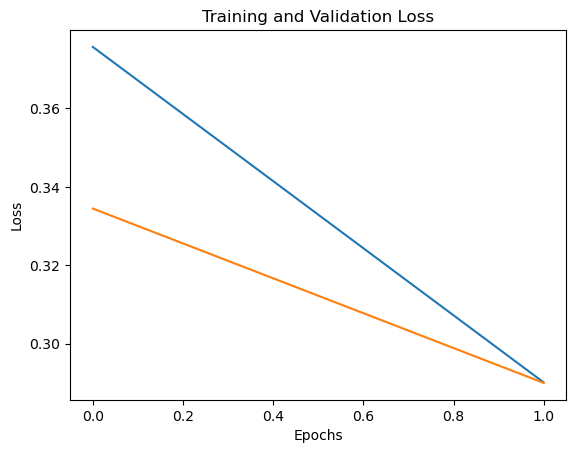

In [19]:
N_EPOCHS = 2
fold = 0
train_loss_history = [0.3756773788109546, 0.2901297879729002]
val_loss_history = [0.33446284999550285, 0.2900072319488699]
        
plt.plot(range(N_EPOCHS), train_loss_history, label='Training Loss')
plt.plot(range(N_EPOCHS), val_loss_history, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(save_path + f'multilabel_efnb4_v1_loss_history_fold{fold}.png')
plt.show()

TypeError: Image data of dtype <U96 cannot be converted to float

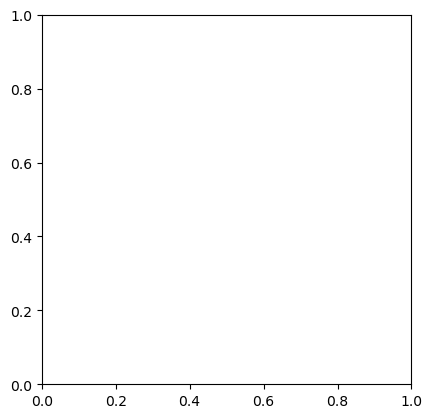

In [20]:
plt.imshow(save_path + f'multilabel_efnb4_v1_loss_history_fold{fold}.png')